# Langfuse for CICD in LLMOPs - Part 1
* Notebook by Adam Lang
* Date: 12/26/2024

# Overview
* This notebook is part 1 of how to utilize Langfuse for LLMOps. 
* First thing you need to do is Setup a Langfuse project and get credentials by going to the Langfuse dashboard link: cloud.langfuse.com
* After doing that, follow steps in dashboard to create a new org --> new project --> Get API key.
* Then create a secret `.env` file with the langfuse credentials, then you can proceed!

In [3]:
## install requirements file
!pip install -r requirements.txt

  Using cached langchain_openai-0.2.14-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain_chroma-0.1.4-py3-none-any.whl.metadata (1.6 kB)
  Using cached wikipedia-1.4.0-py3-none-any.whl
  Using cached pydantic-2.6.1-py3-none-any.whl.metadata (83 kB)
  Using cached langfuse-2.57.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.16.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.5 kB)
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_openai-0.2.13-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain_openai-0.2.12-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain_openai-0.2.11-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain_openai-0.2.10-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_openai-0.2.9-py3-

In [4]:
import dotenv

# OPENAI_API_KEY
# LANGFUSE_SECRET_KEY
# LANGFUSE_PUBLIC_KEY
# LANGFUSE_HOST="https://cloud.langfuse.com"

dotenv.load_dotenv('.env')

True

# Playground demo

- Langfuse playground lets us experiment with different prompts based on our use cases
- once a prompt gives stable output we can then store it for future use

## Playground Demo setup
* To use the Playground in Langfuse you need to setup your `LLM API KEY` which is the API key of the LLM model provider you are using, for example I am going to use OPENAI but if you were going to use Anthropic or Bedrock or Azure you would supply that in your Langfuse dashboard.
* Here is an example using the Playground with OPENAI:
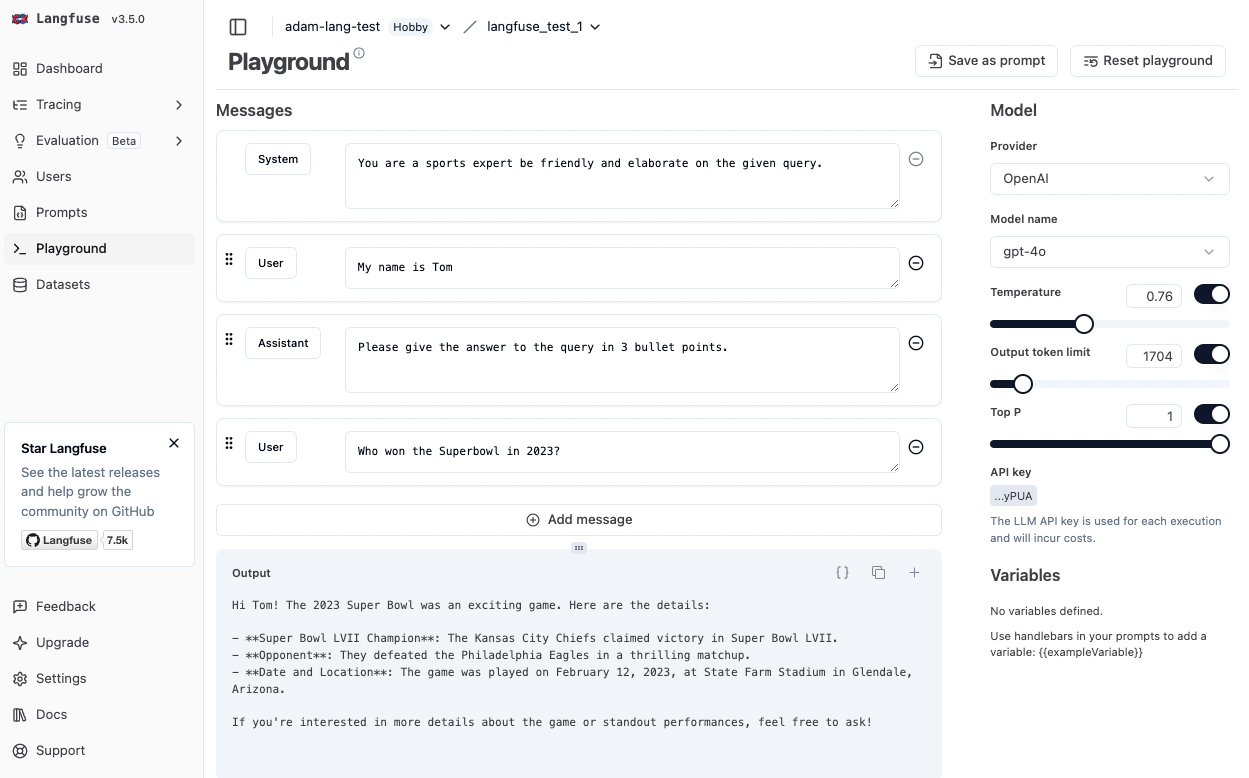


# Prompt management demo
- use can then version and use these prompts in production
- prompts are fetch in real-time and therefore can be used to quicky change the application behaviour

In [5]:
# rag-base-prompt-with-context
message = """
Answer this question using the provided context only.

{{question}}

Context:
{{context}}
"""

## this is the `config` for the prompt
args = {"model": "gpt-4o-mini", "temperature": 0}

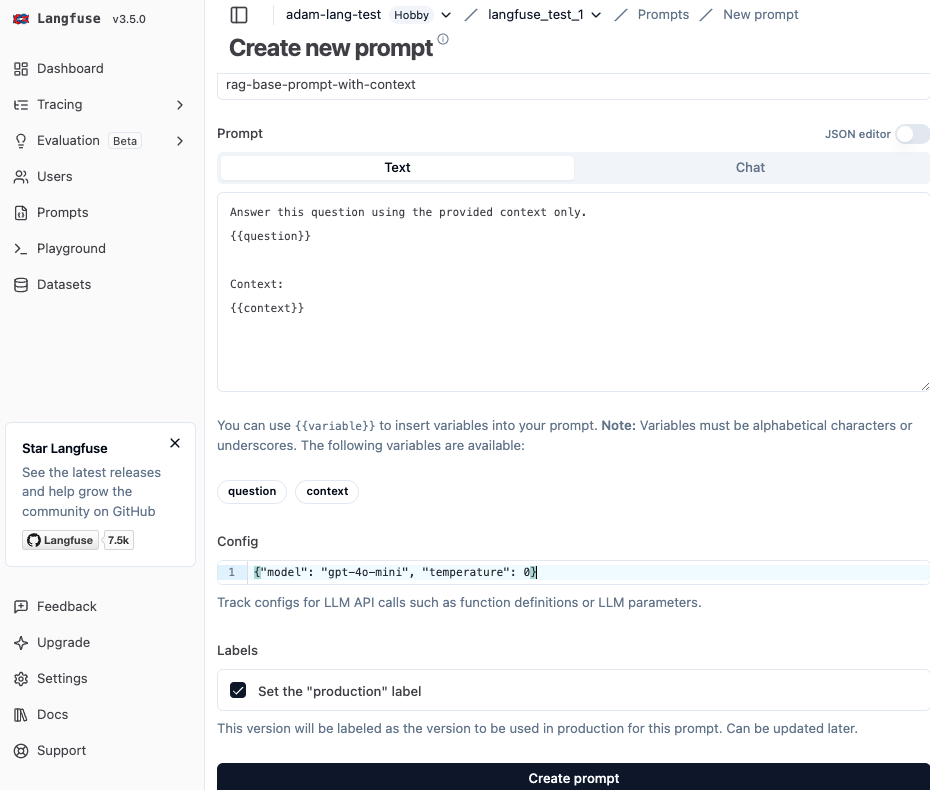

## Prompts are immutable!
* This means that once a prompt has been created, you have to create a new version.
* As we see below, I created a `Version 2` and we can see the `Version 1` was added as the `Production` prompt.

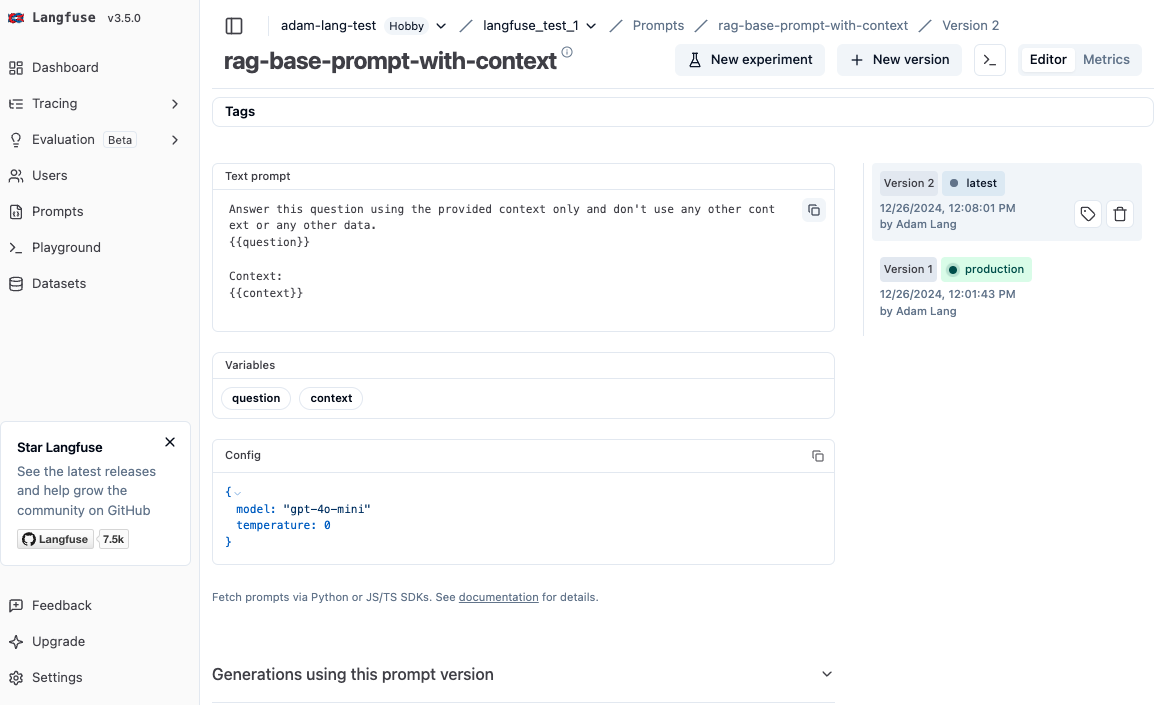

# Decorator based integration
* This demonstrates how we can use the decorator option to trace specific components of an LLM application in production.

In [6]:
from langfuse.decorators import observe, langfuse_context
import openai
 

# decorator to monitor trace -- with call_openai function
@observe(as_type="generation")
def call_openai(session_id, user_id, **kwargs):

  # add metadata to the context --> update with specific metadata
  langfuse_context.update_current_observation(
      input=kwargs["messages"],
      model=kwargs["model"],
      metadata={"max_tokens": kwargs["max_tokens"], "type": "testing"}
  )

  # optional arguments --> add specific metadata to trace
    ## here we can override other values
  langfuse_context.update_current_trace(
    session_id=session_id, 
    user_id=user_id, 
    metadata={"is_openai": bool("gpt" in kwargs["model"])}
)
 
  # return value also monitored --> create chat completion from OPENAI model
  return openai.chat.completions.create(**kwargs).choices[0].message.content

## tracing main function
@observe()
def main(session_id = "", user_id = ""):
  return call_openai(
    session_id,
    user_id,
      model="gpt-4o-mini",
      max_tokens=200,
      messages=[
          {"role": "user", "content": "What is the meaning of life ?"}
      ]
  )

In [7]:
main()

'The meaning of life has been a profound question explored by philosophers, theologians, scientists, and thinkers throughout history. Different cultures and individuals may have varying interpretations, but some common themes include:\n\n1. **Existential Exploration**: Many people find meaning through personal experiences, relationships, and the pursuit of happiness. Existentialists, for example, argue that meaning is not inherent and must be created by each individual through their choices and actions.\n\n2. **Connection and Relationships**: Building connections with others—whether through family, friendships, or community—often provides a sense of purpose and fulfillment.\n\n3. **Contribution and Service**: Many find meaning in helping others, contributing to society, or pursuing a cause larger than themselves, such as social justice, environmental protection, or humanitarian efforts.\n\n4. **Personal Growth and Self-Discovery**: The pursuit of knowledge, self-improvement, and unders

# Simulating Multiple Users in Langfuse
* This demonstrates how to track multiple users input-outputs in Langfuse.
* We will run this code then check the outputs in the Langfuse dashboard.

In [8]:
main(session_id="android")

'The meaning of life is a profound and philosophical question that has been contemplated by humans for centuries. Different cultures, religions, and philosophical traditions offer various interpretations. Some common perspectives include:\n\n1. **Religious Views**: Many religious traditions provide specific teachings about the purpose of life, often involving the worship of a higher power, moral living, and the pursuit of an afterlife.\n\n2. **Philosophical Perspectives**: Philosophers have debated the meaning of life through existentialism, nihilism, and other frameworks. Existentialists might argue that individuals must create their own meaning in a seemingly indifferent universe, while nihilists may suggest that life has no inherent purpose.\n\n3. **Personal Fulfillment**: Some people find meaning through personal fulfillment, connections with others, love, creativity, and contributing to society.\n\n4. **Scientific Perspectives**: From a scientific standpoint, life can be viewed as

In [9]:
main(session_id="ios", user_id="Alice")

'The meaning of life is a philosophical question that has been contemplated for centuries and can vary widely depending on individual beliefs, cultural backgrounds, and personal experiences. Some people find meaning through relationships, love, and community, while others may seek it through personal achievements, spirituality, or pursuing knowledge and understanding.\n\nDifferent philosophical and religious traditions offer various interpretations:\n\n1. **Existentialism**: Suggests that life’s meaning is not predetermined and that individuals must create their own meaning through choices and actions.\n\n2. **Religious perspectives**: Many religions provide frameworks for understanding life’s purpose, often involving serving a higher power, following ethical guidelines, and aiming for a form of afterlife or enlightenment.\n\n3. **Humanism**: Focuses on human values and the importance of reason, emphasizing the importance of human agency in creating meaning.\n\nUltimately, the meaning 

In [10]:
main(session_id="ios", user_id="Bob")

"The meaning of life is a philosophical question that has been explored by thinkers, theologians, and individuals throughout history. There are many interpretations based on cultural, religious, existential, and personal perspectives. Some common themes include:\n\n1. **Religious Perspectives**: Many religious beliefs offer specific meanings, such as fulfilling a divine purpose or living in accordance with spiritual teachings.\n\n2. **Existential Views**: Some philosophies suggest that life has no inherent meaning, and it is up to each individual to create their own purpose and significance.\n\n3. **Human Connection**: Relationships and connections with others are often viewed as central to a meaningful life.\n\n4. **Pursuit of Happiness**: Finding joy, fulfillment, and satisfaction in experiences and achievements can be seen as a key aspect of life's meaning.\n\n5. **Contribution to Society**: Making a positive impact on the world and contributing to the well-being of others can be vi

# Viewing Traces in Langfuse
* We can drill down in the Langfuse dashboard into the traces created above such as this:
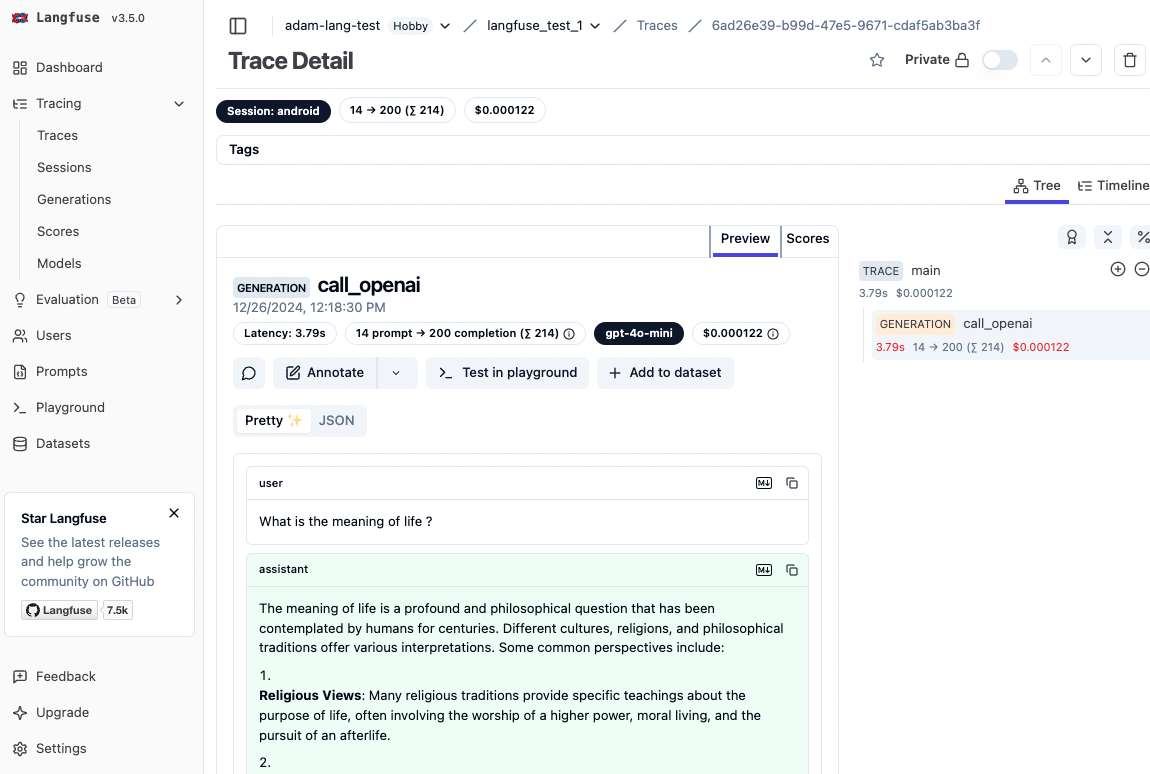

* The traces show up in the main Traces dashboard everytime a new trace is tracked in the system.
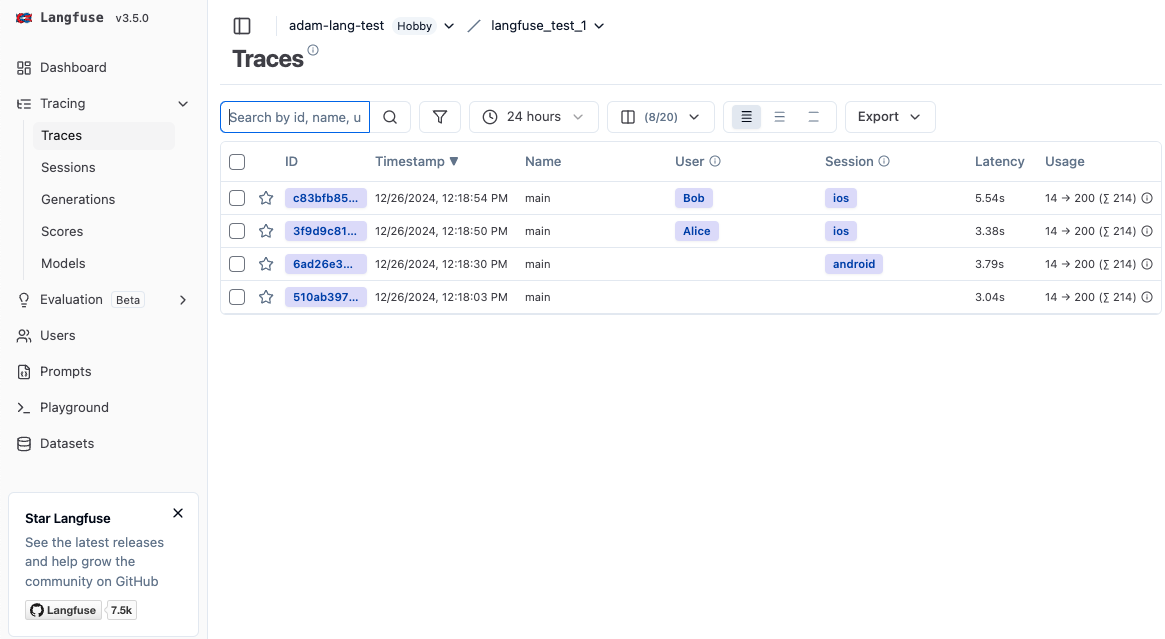

# Sessions in Langfuse
* We can see specific user sessions in the dashboard.
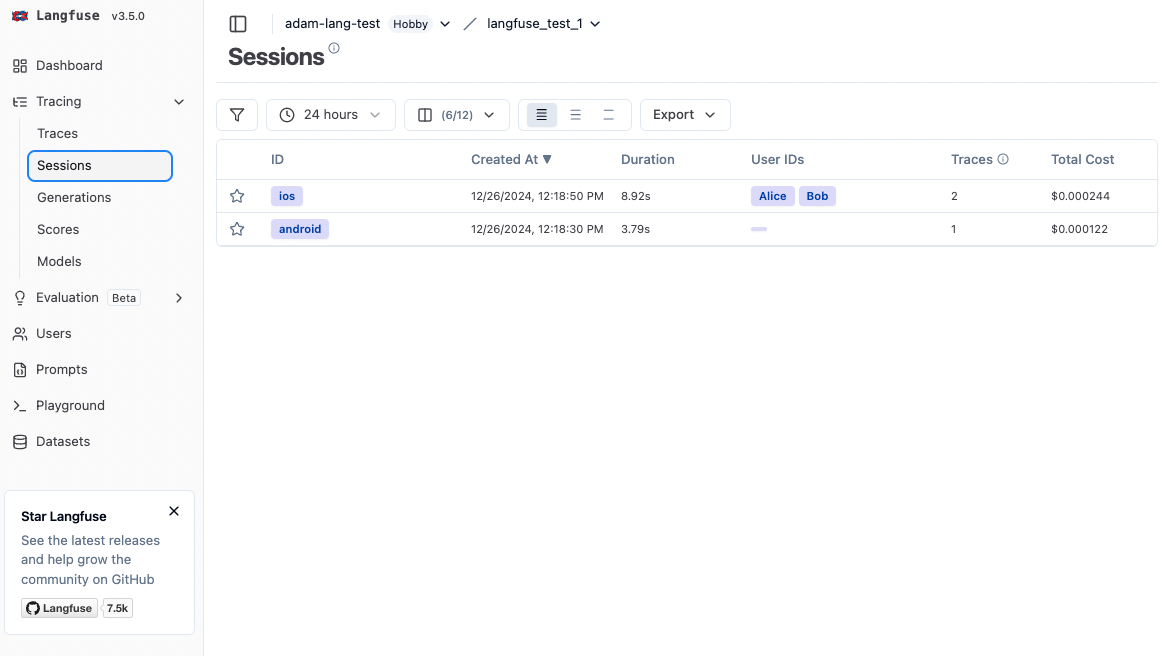

# Users in Langfuse
* We can also monitor specific users in the system as we see below.
* We can drill down into each user as an example below.

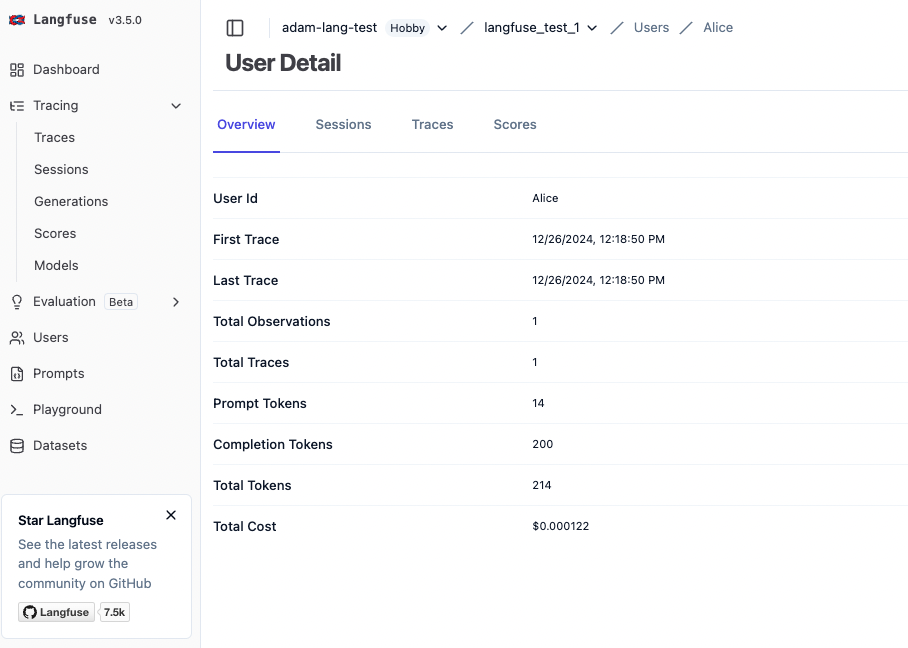